In [3]:
import os
import numpy as np
import torch
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import pandas as pd
import wandb
from ultralytics import YOLO


In [4]:
test_set_path = r"C:\Users\samue\OneDrive\AIML\FS2025\DSPRO\Testset\Images\test_images_SID03\test"
csv_path = r"C:\Users\samue\OneDrive\AIML\FS2025\DSPRO\Testset\bboxes_test.csv"


In [5]:

# Login to wandb
wandb.login()
api = wandb.Api()

# Download the YOLO model artifact from wandb
artifact = api.artifact('rueedi-tobias-hochschule-luzern/V1_2-maize_disease_detection_train/run_im166j19_model:v0', type='model')
model_dir = artifact.download()

# Find the model file (usually .pt for YOLO)
model_file = None
for file in os.listdir(model_dir):
    if file.endswith(".pt"):
        model_file = os.path.join(model_dir, file)
        break

# Load the model with Ultralytics
if model_file:
    model = YOLO(model_file)
    model.to('cpu')  
    #model.to('cuda')
    print("Model loaded:", model_file)
else:
    print("No .pt model file found in artifact.")


wandb: Currently logged in as: samutheman (rueedi-tobias-hochschule-luzern) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb:   1 of 1 files downloaded.  


Model loaded: c:\Users\samue\OneDrive\AIML\FS2025\DSPRO\M-AI-ZE-Maize-diseases-detection\notebooks\artifacts\run_im166j19_model-v0\best.pt


In [6]:
def get_gt_boxes_from_csv(csv_path, image_paths):
    df = pd.read_csv(csv_path)
    gt_dict = {}
    for _, row in df.iterrows():
        fname = row['image']
        img_path = None
        for p in image_paths:
            if os.path.basename(p) == fname:
                img_path = p
                break
        if img_path is None or not os.path.exists(img_path):
            continue
        with Image.open(img_path) as img:
            w, h = img.size
        # CSV columns: x1, y1, x2, y2 (pixel)
        box = [row['x1']/w, row['y1']/h, row['x2']/w, row['y2']/h]
        if fname not in gt_dict:
            gt_dict[fname] = []
        gt_dict[fname].append(box)
    gt_boxes_list = []
    for path in image_paths:
        fname = os.path.basename(path)
        gt_boxes = gt_dict.get(fname, [])
        gt_boxes_list.append(gt_boxes)
    return gt_boxes_list


gt_boxes_list = get_gt_boxes_from_csv(csv_path, test_set_path)

In [7]:
def predict_yolo_ultralytics(model, pil_image, conf=0.25):
    results = model(pil_image)
    pred_boxes = []
    for r in results:
        for box in r.boxes.xyxy.cpu().numpy():
            x1, y1, x2, y2 = box[:4]
            w, h = pil_image.size
            pred_boxes.append([x1/w, y1/h, x2/w, y2/h])
    return pred_boxes

In [17]:
def load_images_from_folder(folder_path, num_images=None):
    image_paths = [os.path.join(folder_path, f)
                   for f in os.listdir(folder_path)
                   if f.lower().endswith((".jpg", ".jpeg", ".png"))]
    image_paths = sorted(image_paths)
    if num_images:
        image_paths = image_paths[:num_images]
    images = []
    originals = []
    for path in image_paths:
        img = Image.open(path).convert("RGB")
        originals.append(img.copy())
        images.append(img)
    print(f"Loaded {len(images)} image(s) from: {folder_path}")
    return images, originals, image_paths

images, originals, image_paths = load_images_from_folder(test_set_path, num_images=20)

Loaded 20 image(s) from: C:\Users\samue\OneDrive\AIML\FS2025\DSPRO\Testset\Images\test_images_SID03\test


In [9]:
def overlay_boxes_on_image(original_image, boxes, color=(255, 0, 0), alpha=0.4):
    """
    Overlays colored (transparent) regions for each box on a PIL image.
    Args:
        original_image: PIL.Image (will not be modified in-place)
        boxes: list or np.array of [x1, y1, x2, y2] in relative coords (0–1)
        color: RGB tuple for overlay color (default: red)
        alpha: transparency (0=transparent, 1=opaque)
    Returns:
        PIL.Image with overlay
    """
    image = original_image.convert("RGBA")
    overlay = Image.new("RGBA", image.size, (0, 0, 0, 0))
    draw = ImageDraw.Draw(overlay)
    w, h = image.size

    for box in boxes:
        x1, y1, x2, y2 = box
        x1, y1 = int(x1 * w), int(y1 * h)
        x2, y2 = int(x2 * w), int(y2 * h)
        draw.rectangle([x1, y1, x2, y2], fill=color + (int(255 * alpha),))

    combined = Image.alpha_composite(image, overlay)
    return combined.convert("RGB")


0: 448x640 2 lesions, 789.3ms
Speed: 10.8ms preprocess, 789.3ms inference, 6.8ms postprocess per image at shape (1, 3, 448, 640)


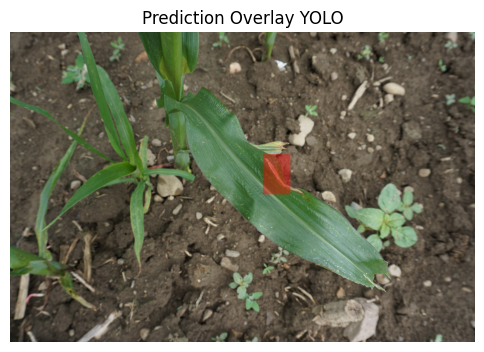

In [10]:
for i in range(len(images)):
    pil_img = images[i]
    original_image = originals[i]
    pred_boxes = predict_yolo_ultralytics(model, pil_img, conf=0.3)
    pred_overlay = overlay_boxes_on_image(original_image, pred_boxes, color=(255, 0, 0), alpha=0.4)
    plt.figure(figsize=(6, 6))
    plt.imshow(pred_overlay)
    plt.title("Prediction Overlay YOLO")
    plt.axis("off")
    plt.show()

In [15]:
# This dictionary will store the output of the layer we are "hooking" into.
feature_outputs = {}

def get_features_hook(module, input, output):
    """A simple hook function to save the output of a layer."""
    feature_outputs['features'] = output

def plot_heatmap_overlay(model, pil_img, target_size=(640, 640), alpha=0.6):
    """
    Generates a feature map heatmap and overlays it on the original image.

    Args:
        model (torch.nn.Module): The PyTorch model.
        pil_img (PIL.Image.Image): The input image.
        target_size (tuple, optional): The size to resize the input image to. Defaults to (640, 640).
        alpha (float, optional): The transparency of the heatmap overlay (0.0 to 1.0). 
                                 Defaults to 0.6.
    """
    # === Part 1: Get the feature map using the hook method ===
    device = next(model.model.parameters()).device
    
    img_resized = pil_img.resize(target_size).convert("RGB")
    img_tensor = torch.from_numpy(np.array(img_resized)).permute(2, 0, 1).float() / 255.0
    img_tensor = img_tensor.unsqueeze(0).to(device)

    target_layer_index = model.model.model[-1].i - 1
    target_layer = model.model.model[target_layer_index]

    hook_handle = target_layer.register_forward_hook(get_features_hook)
    
    with torch.no_grad():
        model(img_tensor)

    hook_handle.remove()
    
    last_features = feature_outputs['features']
    heatmap = last_features.squeeze(0).mean(dim=0).cpu().numpy()

    # === Part 2: Create and overlay the heatmap ===

    # Normalize the heatmap to the 0-1 range
    heatmap_normalized = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap))

    # Resize the heatmap to match the image size
    heatmap_pil = Image.fromarray(heatmap_normalized)
    heatmap_resized = heatmap_pil.resize(img_resized.size, Image.LANCZOS)
    
    # Apply a colormap to the heatmap
    colormap = plt.get_cmap('inferno')
    heatmap_colored_np = colormap(np.array(heatmap_resized))[:, :, :3] * 255
    heatmap_colored_pil = Image.fromarray(heatmap_colored_np.astype(np.uint8))

    # Blend the original image with the colored heatmap
    overlay_image = Image.blend(img_resized, heatmap_colored_pil, alpha=alpha)

    # === Part 3: Plot the result ===
    plt.figure(figsize=(10, 10))
    plt.imshow(overlay_image)
    plt.title(f"Heatmap Overlay (Layer {target_layer_index})")
    plt.axis('off')
    plt.show()

In [23]:
model.eval()

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (act): SiLU(inplace=True)
      )
      (2): C3k2(
        (cv1): Conv(
          (conv): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU(inplace=True)
        )
        (m): ModuleList(
          (0-1): 2 x C3k(
            (cv1): Conv(
              (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
              (act): SiLU(inplace=True)
            )
            (cv2): Conv(
              (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
              (act): SiLU(inplace=True)
            )
            (cv3


0: 640x640 16 lesions, 451.0ms
Speed: 0.0ms preprocess, 451.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


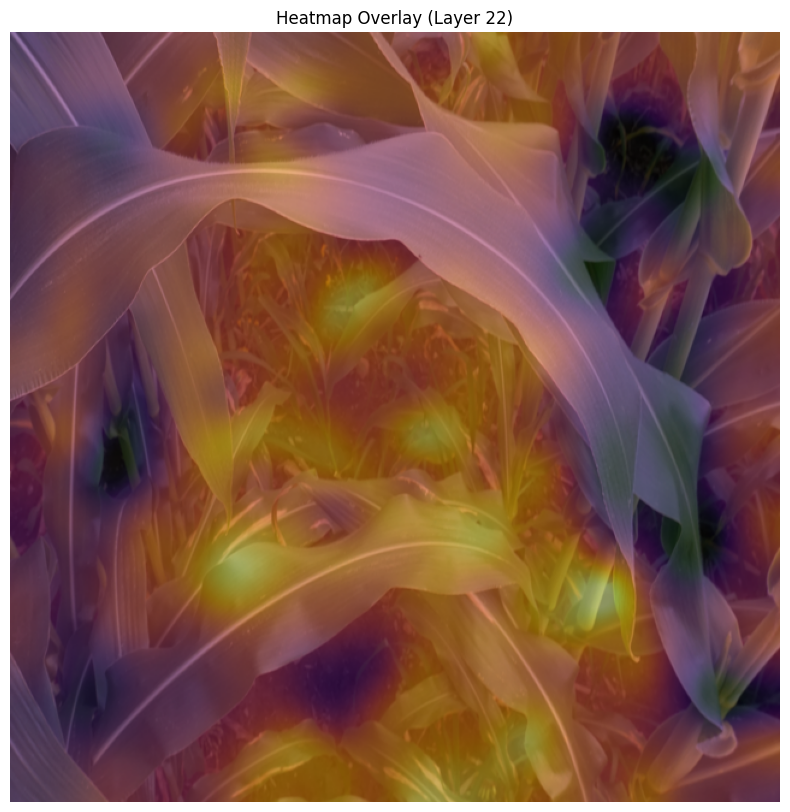

In [34]:
plot_heatmap_overlay(model, images[16], alpha=0.5)
